In [1]:
import asyncio
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
import random
import os
import sys
import shutil

from inspect import iscoroutinefunction
from timeout_function_decorator import timeout
from statistics import mean, median_low

In [2]:
sns.set_theme('notebook')
sns.set_palette('colorblind')

log_format = "%(asctime)s - %(levelname)s: %(message)s"
logging.basicConfig(format=log_format)

In [3]:
MAX_TIME = 0.1
NUMBER_OF_EXPERIMENTS = 50
HARD_CAP = 500

In [4]:
def quick_sync_func(a, b):
    return a + b

def medium_sync_func(a, b):
    for _ in range(1000):
        a += b
    return a + b

def long_sync_func(a, b):
    for _ in range(10_000):
        a += b
    return a + b

def huge_sync_func(a, b):
    for _ in range(100_000):
        a += b
    return a + b

@timeout(1)
def quick_timeout_sync_func(a, b):
    return a + b

@timeout(1)
def medium_timeout_sync_func(a, b):
    for _ in range(1000):
        a += b
    return a + b

@timeout(1)
def long_timeout_sync_func(a, b):
    for _ in range(10_000):
        a += b
    return a + b

@timeout(1)
def huge_timeout_sync_func(a, b):
    for _ in range(100_000):
        a += b
    return a + b

In [5]:
async def quick_async_func(a, b):
    return a + b

async def medium_async_func(a, b):
    for _ in range(1000):
        a += b
    return a + b

async def long_async_func(a, b):
    for _ in range(10_000):
        a += b
    return a + b

async def huge_async_func(a, b):
    for _ in range(100_000):
        a += b
    return a + b

@timeout(1)
async def quick_timeout_async_func(a, b):
    return a + b

@timeout(1)
async def medium_timeout_async_func(a, b):
    for _ in range(1000):
        a += b
    return a + b

@timeout(1)
async def long_timeout_async_func(a, b):
    for _ in range(10_000):
        a += b
    return a + b

@timeout(1)
async def huge_timeout_async_func(a, b):
    for _ in range(100_000):
        a += b
    return a + b

In [6]:
def sync_experiment(func, n):
    logging.info(f"Starting sync experiment with function {func.__name__} with {n} calls...")
    a = 42
    b = 69
    start = time.time()
    for i in range(n):
        func(a, b)
    end = time.time()
    logging.info(f"Completed sync experiment with function {func.__name__} with {n} calls in {end - start} seconds...")
    return end - start

async def async_experiment(func, n):
    logging.info(f"Starting async experiment with function {func.__name__} with {n} calls...")
    a = 42
    b = 69
    start = time.time()
    for i in range(n):
        await func(a, b)
    end = time.time()
    logging.info(f"Completed async experiment with function {func.__name__} with {n} calls in {end - start} seconds...")
    return end - start

In [7]:
async def experiment_manager(func, experiment_length, number_of_experiments):
    logging.info(f"Starting experiment battery calling function {func.__name__} {experiment_length} times. Battery will be repeated {number_of_experiments} times...")
    avg = []
    if iscoroutinefunction(func):
        for _ in range(number_of_experiments):
            tmp = await async_experiment(func, experiment_length)
            avg.append(tmp)
    else:
        for _ in range(number_of_experiments):
            tmp = sync_experiment(func, experiment_length)
            avg.append(tmp)
    logging.info(f"Completed experiment battery calling function {func.__name__} {experiment_length} times. Battery has been repeated {number_of_experiments} times and took an average of {mean(avg)} seconds.")
    return mean(avg)

In [8]:
df = pd.DataFrame(columns=['function', 'number of calls', 'time to complete', 'timeout', 'async'])

In [9]:
async def create_data(func, wrapped, df):
    logging.info(f"Creating data for function {func.__name__}...")
    is_async = iscoroutinefunction(func)
    current_time = 0
    current_lenth = 1
    while current_time < MAX_TIME and current_lenth <= HARD_CAP:
        current_time = await experiment_manager(func, current_lenth, NUMBER_OF_EXPERIMENTS)
        df.loc[len(df.index)] = [func.__name__, current_lenth, current_time, wrapped, is_async]
        current_lenth += 1
    logging.info(f"Created data for function {func.__name__}...")

In [10]:
await create_data(quick_sync_func, False, df)

In [11]:
await create_data(quick_timeout_sync_func, True, df)

In [12]:
await create_data(medium_sync_func, False, df)

In [13]:
await create_data(medium_timeout_sync_func, True, df)

In [14]:
await create_data(long_sync_func, False, df)

In [15]:
await create_data(long_timeout_sync_func, True, df)

In [16]:
await create_data(huge_sync_func, False, df)

In [17]:
await create_data(huge_timeout_sync_func, True, df)

In [18]:
await create_data(quick_async_func, False, df)

In [19]:
await create_data(quick_timeout_async_func, True, df)

In [20]:
await create_data(medium_async_func, False, df)

In [21]:
await create_data(medium_timeout_async_func, True, df)

In [22]:
await create_data(long_async_func, False, df)

In [23]:
await create_data(long_timeout_async_func, True, df)

In [24]:
await create_data(huge_async_func, False, df)

In [25]:
await create_data(huge_timeout_async_func, True, df)

In [26]:
logging.info("Clearing performance folder...")

In [27]:
if os.path.isdir("../performance"):
    shutil.rmtree("../performance")
os.makedirs("../performance")

In [28]:
logging.info("Creating plots...")

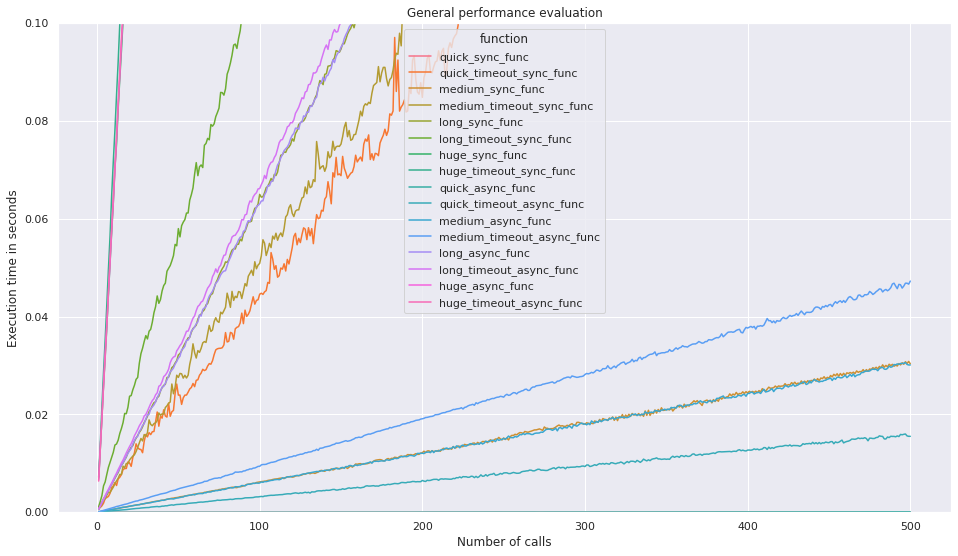

In [29]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df, x='number of calls', y='time to complete', hue='function')
plt.title('General performance evaluation')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig("../performance/general.png", backend='agg', dpi=300)
plt.show()

In [30]:
df_sync = df.query('`async` == False')
df_async = df.query('`async` == True')

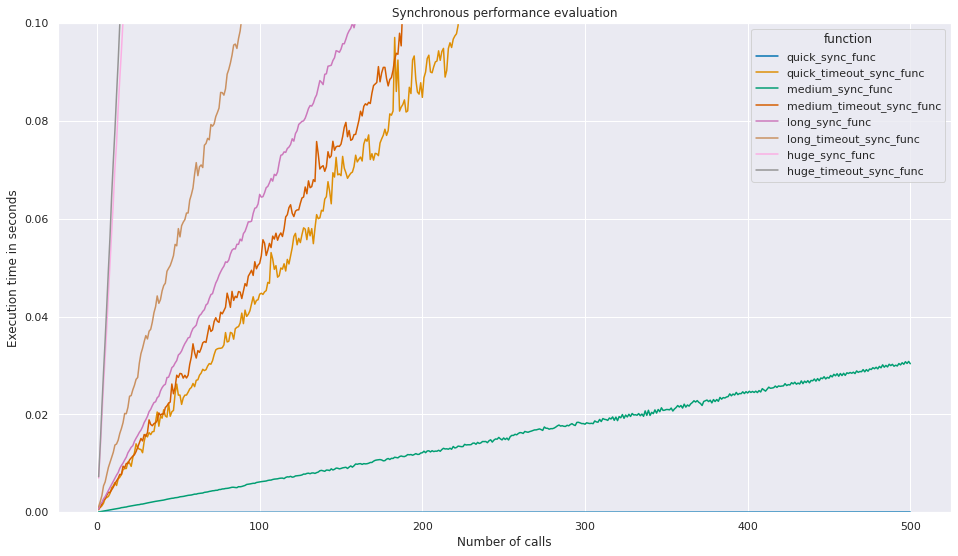

In [31]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_sync, x='number of calls', y='time to complete', hue='function')
plt.title('Synchronous performance evaluation')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig("../performance/sync.png", backend='agg', dpi=200)
plt.show()

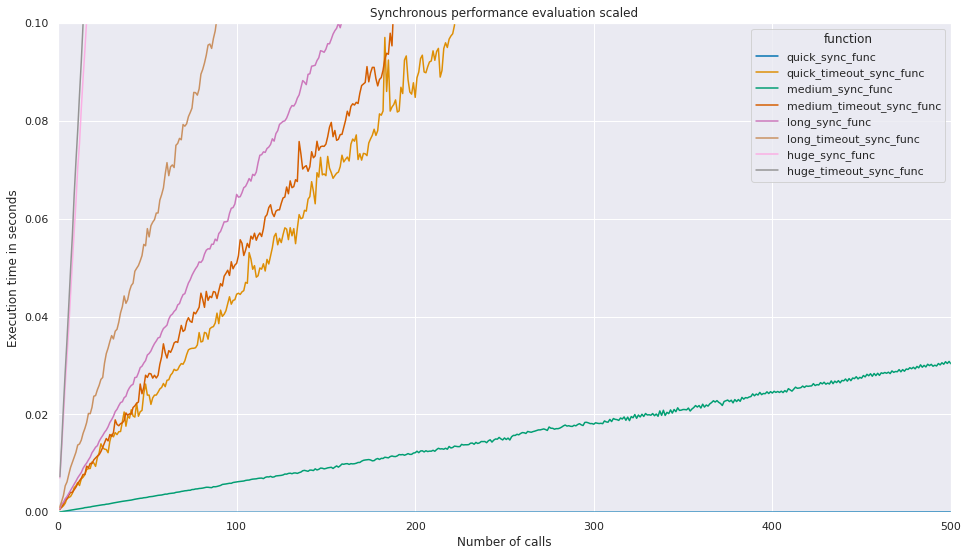

In [32]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_sync, x='number of calls', y='time to complete', hue='function')
plt.title('Synchronous performance evaluation scaled')
plt.ylim(0, MAX_TIME)
plt.xlim(0, df_sync.query("not function.str.contains('quick')")['number of calls'].max())
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.show()

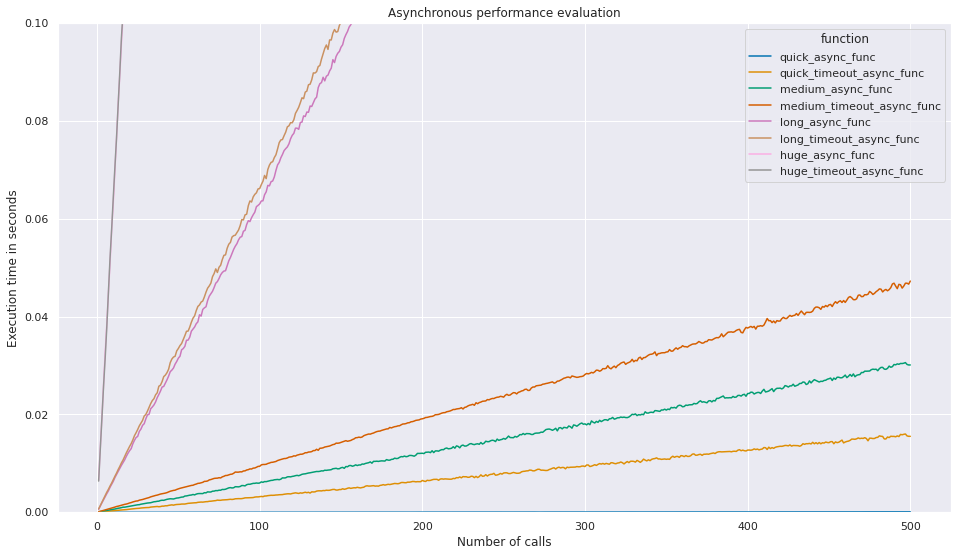

In [33]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_async, x='number of calls', y='time to complete', hue='function')
plt.title('Asynchronous performance evaluation')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig('../performance/async.png', backend='agg', dpi=200)
plt.show()

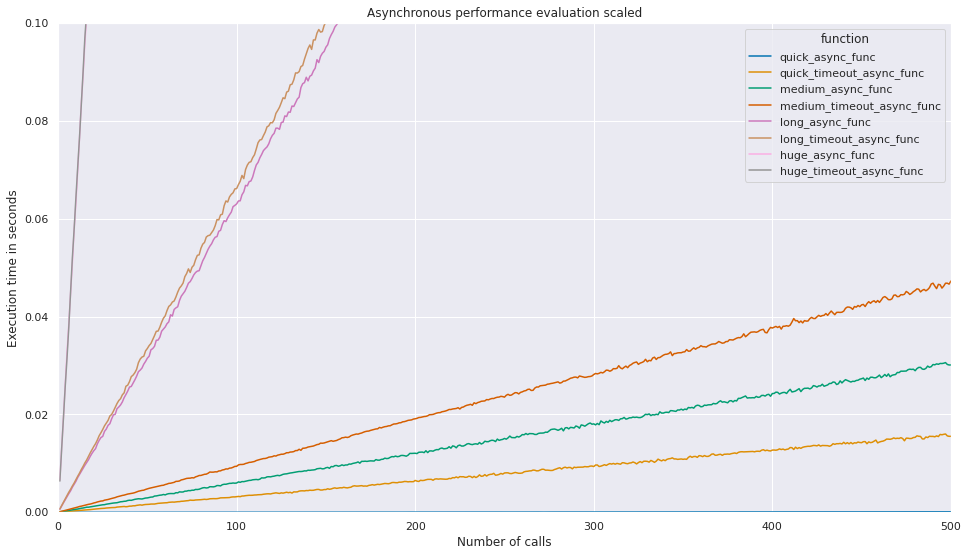

In [34]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_async, x='number of calls', y='time to complete', hue='function')
plt.title('Asynchronous performance evaluation scaled')
plt.ylim(0, MAX_TIME)
plt.xlim(0, df_async.query("not function.str.contains('quick')")['number of calls'].max())
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.show()

In [35]:
df_quick_async = df_async.query('function.str.contains("quick")')
df_quick_sync = df_sync.query('function.str.contains("quick")')

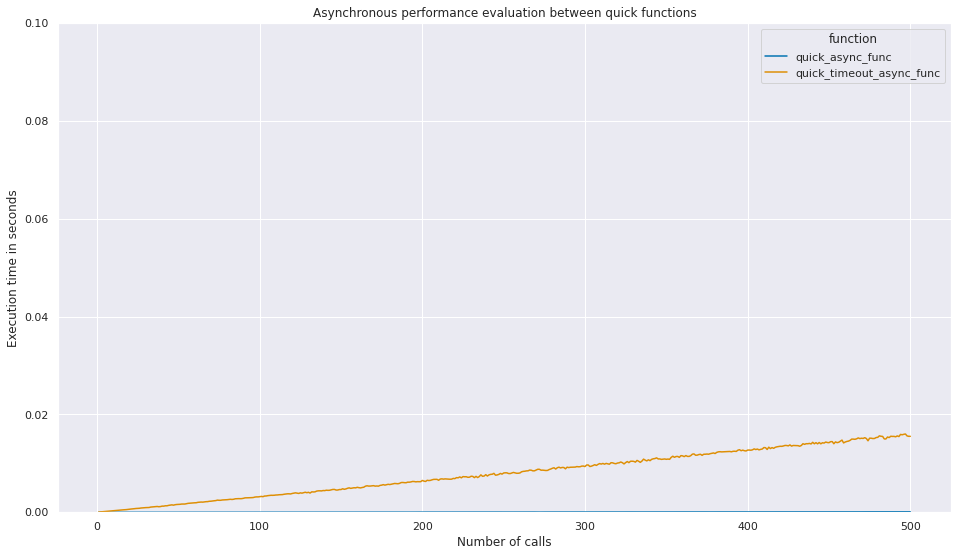

In [36]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_quick_async, x='number of calls', y='time to complete', hue='function')
plt.title('Asynchronous performance evaluation between quick functions')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig("../performance/async_quick.png", backend='agg')
plt.show()

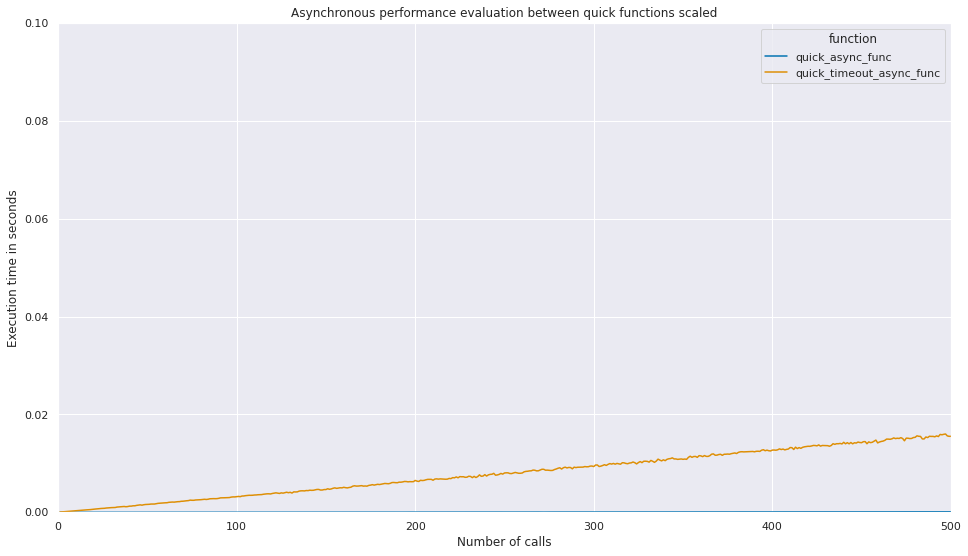

In [37]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_quick_async, x='number of calls', y='time to complete', hue='function')
plt.title('Asynchronous performance evaluation between quick functions scaled')
plt.ylim(0, MAX_TIME)
plt.xlim(0, df_quick_async.query("timeout == True")['number of calls'].max())
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.show()

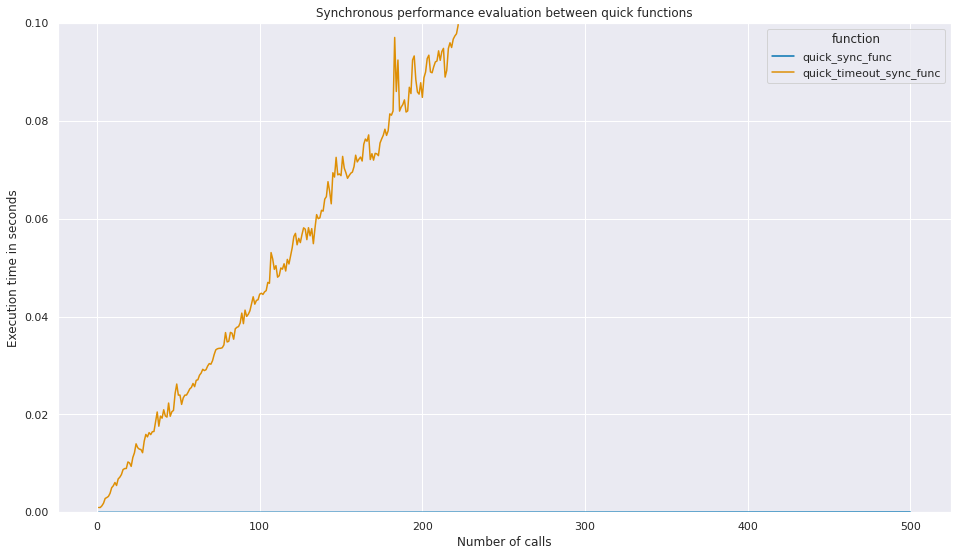

In [38]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_quick_sync, x='number of calls', y='time to complete', hue='function')
plt.title('Synchronous performance evaluation between quick functions')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig('../performance/sync_quick.png', backend='agg')
plt.show()

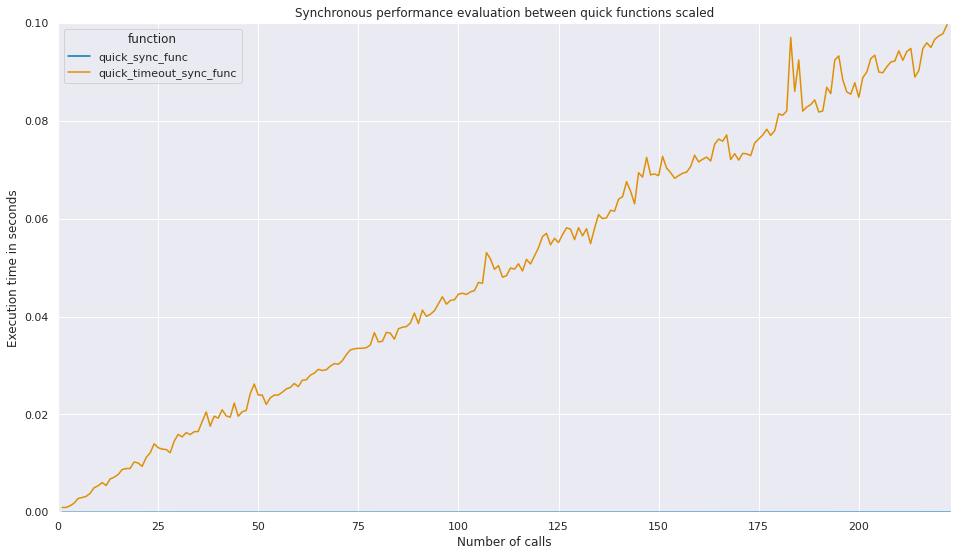

In [39]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_quick_sync, x='number of calls', y='time to complete', hue='function')
plt.title('Synchronous performance evaluation between quick functions scaled')
plt.ylim(0, MAX_TIME)
plt.xlim(0, df_quick_sync.query("timeout == True")['number of calls'].max())
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.show()

In [40]:
df_medium_sync = df_sync.query("function.str.contains('medium')")
df_medium_async = df_async.query("function.str.contains('medium')")

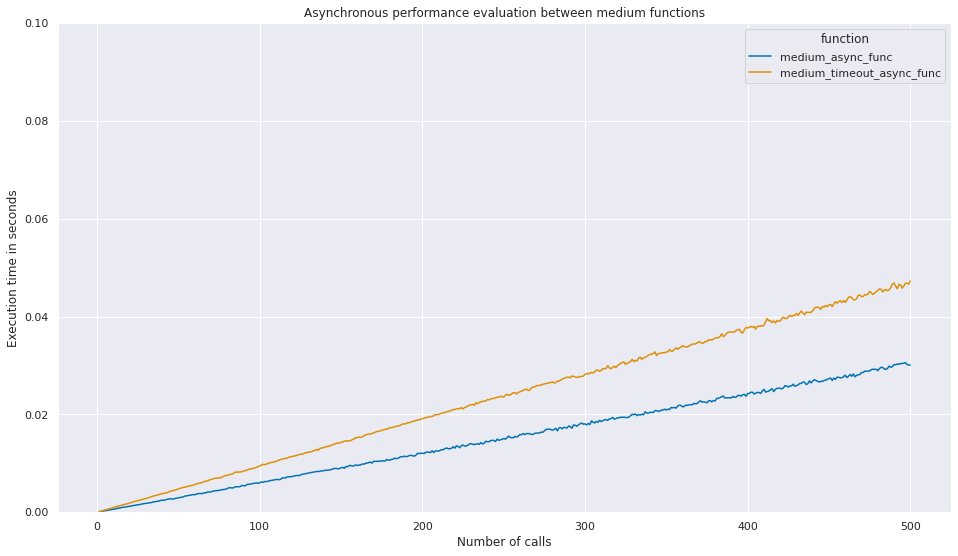

In [41]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_medium_async, x='number of calls', y='time to complete', hue='function')
plt.title('Asynchronous performance evaluation between medium functions')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig('../performance/async_medium.png', backend='agg')
plt.show()

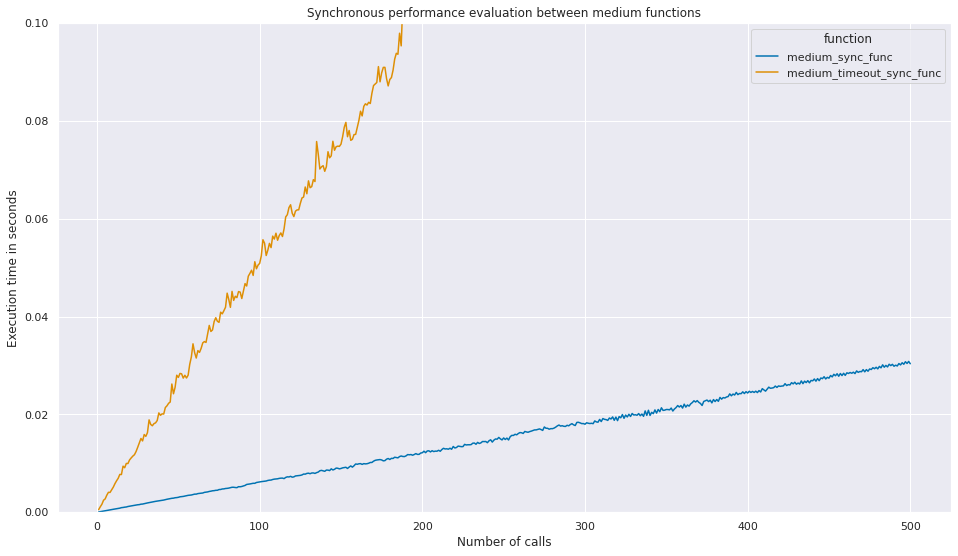

In [42]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_medium_sync, x='number of calls', y='time to complete', hue='function')
plt.title('Synchronous performance evaluation between medium functions')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig('../performance/sync_medium.png', backend='agg')
plt.show()

In [43]:
df_long_sync = df_sync.query("function.str.contains('long')")
df_long_async = df_async.query("function.str.contains('long')")

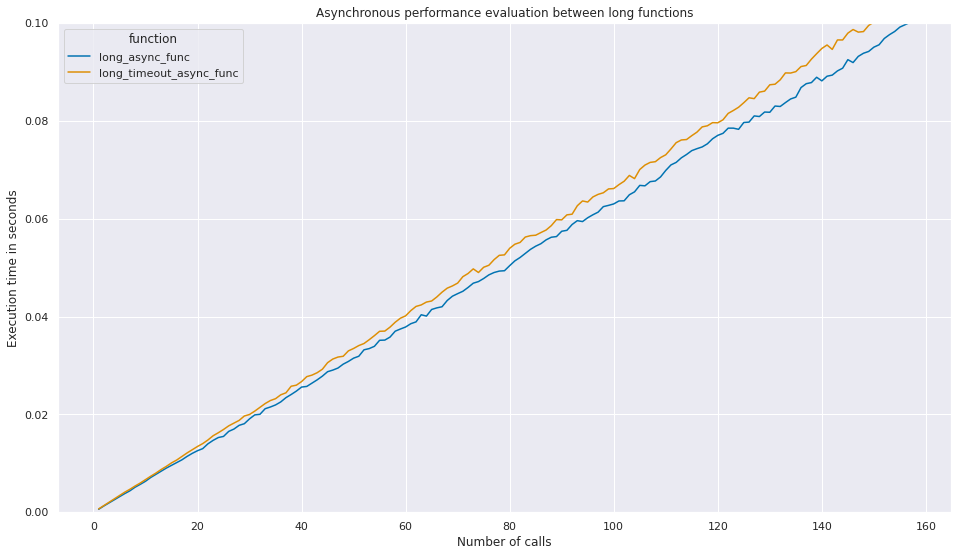

In [44]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_long_async, x='number of calls', y='time to complete', hue='function')
plt.title('Asynchronous performance evaluation between long functions')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig('../performance/async_long.png', backend='agg')
plt.show()

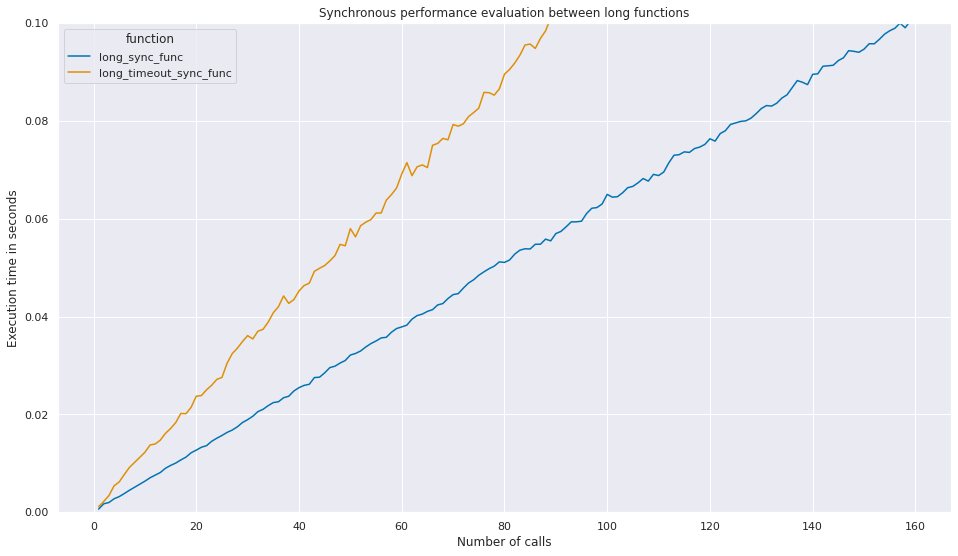

In [45]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_long_sync, x='number of calls', y='time to complete', hue='function')
plt.title('Synchronous performance evaluation between long functions')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig('../performance/sync_long.png', backend='agg')
plt.show()

In [46]:
df_huge_sync = df_sync.query("function.str.contains('huge')")
df_huge_async = df_async.query("function.str.contains('huge')")

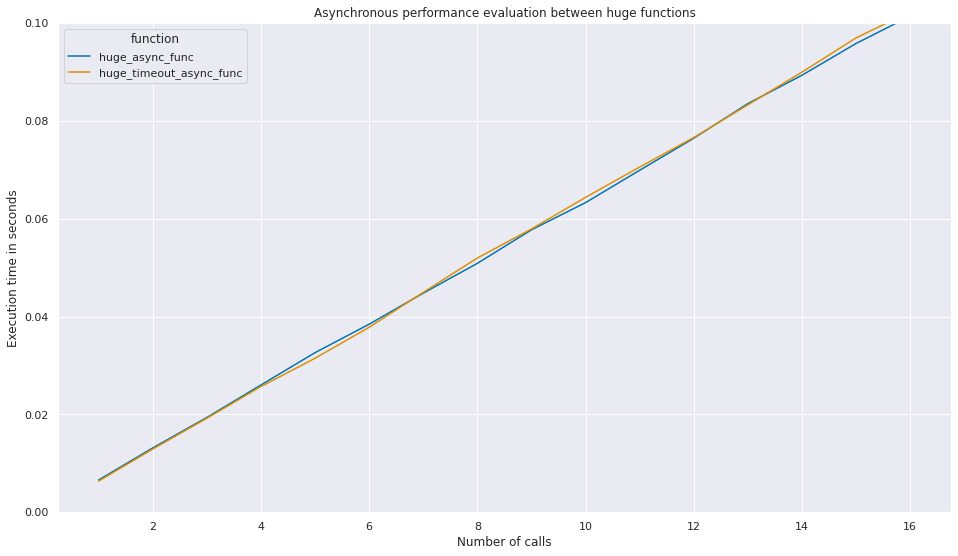

In [47]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_huge_async, x='number of calls', y='time to complete', hue='function')
plt.title('Asynchronous performance evaluation between huge functions')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig('../performance/async_huge.png', backend='agg')
plt.show()

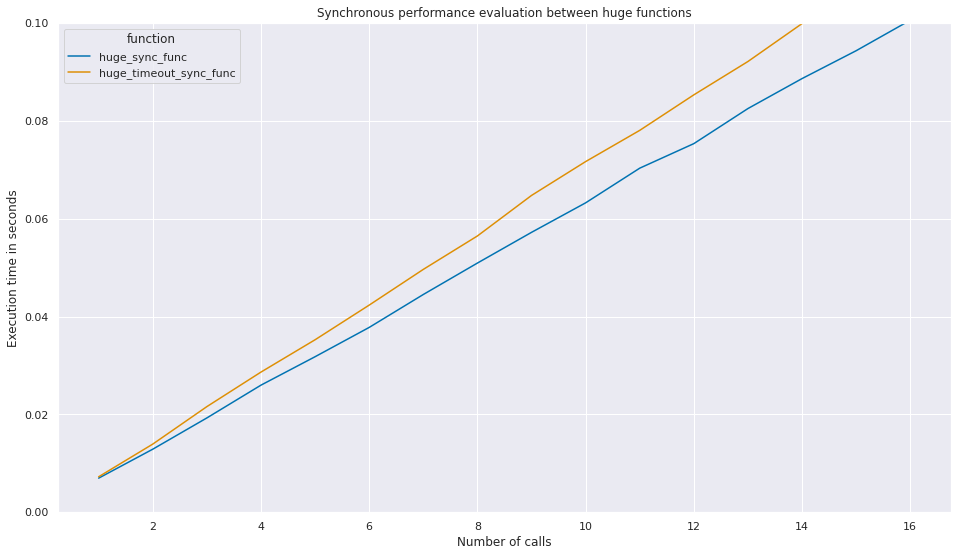

In [48]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_huge_sync, x='number of calls', y='time to complete', hue='function')
plt.title('Synchronous performance evaluation between huge functions')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig('../performance/sync_huge.png', backend='agg')
plt.show()